In [1]:
import scanpy as sc
import surgeon
import numpy as np
sc.settings.set_figure_params(dpi=200)

Using TensorFlow backend.


In [2]:
condition_key = "Method"
cell_type_key = 'CellType'
target_condition = "Drop-seq"

# Loading 6 PBMC datasets and data preparation

In [3]:
adata = sc.read("./data/pbmc/broad_pbmc_count.h5ad")
adata

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 20555 × 33694 
    obs: 'Experiment', 'Method', 'CBC', 'CellType'
    var: 'ENS', 'Name'

## Number of cells in each batch

In [4]:
adata.obs[condition_key].value_counts()

inDrops              6584
Drop-seq             6584
10x Chromium V2 B    3222
10x Chromium V2 A    3222
Smart-seq2            526
CEL-Seq2              417
Name: Method, dtype: int64

## visualization  of the original data

In [ ]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

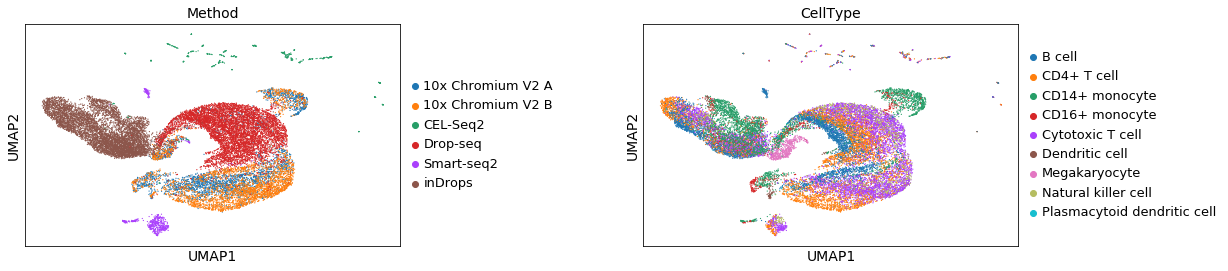

In [6]:
sc.pl.umap(adata, color=[condition_key, cell_type_key], wspace=0.5)

## Now we leave out one study  (Drop-seq) for training the newtork

In [5]:
adata_for_training = adata[adata.obs[condition_key] != target_condition]
adata_for_training

View of AnnData object with n_obs × n_vars = 13971 × 33694 
    obs: 'Experiment', 'Method', 'CBC', 'CellType'
    var: 'ENS', 'Name'

In [ ]:
sc.pl.umap(adata_for_training, color=[condition_key, cell_type_key], wspace=0.5)

In [7]:
adata_out_of_sample = adata[adata.obs[condition_key] == target_condition]
adata_out_of_sample

View of AnnData object with n_obs × n_vars = 6584 × 33694 
    obs: 'Experiment', 'Method', 'CBC', 'CellType'
    var: 'ENS', 'Name'

## Normalization

In [8]:
adata_for_training = surgeon.utils.normalize(adata_for_training, 
                                             filter_min_counts=False, 
                                             normalize_input=False, 
                                             size_factors=True,
                                             logtrans_input=True,
                                             n_top_genes=2000,
                                            )

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [9]:
adata_out_of_sample = surgeon.utils.normalize(adata_out_of_sample, 
                                              filter_min_counts=False, 
                                              normalize_input=False, 
                                              size_factors=True,
                                              logtrans_input=True,
                                              n_top_genes=2000,
                                             )

Trying to set attribute `.obs` of view, making a copy.


## Train/Test Split

In [10]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_for_training, 0.85)

In [11]:
train_adata.shape, valid_adata.shape

((11875, 2000), (2096, 2000))

In [12]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())

# Create & Train model with training data

In [13]:
network = surgeon.archs.CVAE(x_dimension=train_adata.shape[1], 
                             z_dimension=20,
                             n_conditions=n_conditions,
                             lr=0.001,
                             alpha=0.001,
                             eta=1.0,
                             clip_value=100.0,
                             loss_fn='nb',
                             model_path="./models/CVAE/Pancreas/",
                             dropout_rate=0.2,
                             )

/home/icb/mohsen.naghipourfar/scnet/surgeon/models/_cvae.py:146: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  output=h_disp)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 5)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 2005)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
first_layer (Dense)             (None, 512)          1026560     concatenate_1[0][0]              
__________

## We assign each study to a numerical label 

In [14]:
condition_encoder = {'inDrops': 0, '10x Chromium V2 B': 1, '10x Chromium V2 A': 2, 'Smart-seq2': 3, 'CEL-Seq2': 4}

## Training the network

In [15]:
network.train(train_adata,
              valid_adata, 
              condition_key=condition_key,
              le=condition_encoder, 
              n_epochs=200,
              batch_size=128, 
              early_stop_limit=20,
              lr_reducer=15, 
              save=True, 
              verbose=2)

Train on 11875 samples, validate on 2096 samples
Epoch 1/200
 - 9s - loss: 0.3718 - nb: 0.3718 - val_loss: 0.3950 - val_nb: 0.3950
Epoch 2/200
 - 3s - loss: 0.2184 - nb: 0.2184 - val_loss: 0.2377 - val_nb: 0.2377
Epoch 3/200
 - 3s - loss: 0.2107 - nb: 0.2107 - val_loss: 0.2153 - val_nb: 0.2153
Epoch 4/200
 - 3s - loss: 0.2082 - nb: 0.2082 - val_loss: 0.2090 - val_nb: 0.2090
Epoch 5/200
 - 3s - loss: 0.2069 - nb: 0.2069 - val_loss: 0.2081 - val_nb: 0.2081
Epoch 6/200
 - 3s - loss: 0.2061 - nb: 0.2061 - val_loss: 0.2064 - val_nb: 0.2064
Epoch 7/200
 - 3s - loss: 0.2054 - nb: 0.2054 - val_loss: 0.2056 - val_nb: 0.2056
Epoch 8/200
 - 3s - loss: 0.2046 - nb: 0.2046 - val_loss: 0.2051 - val_nb: 0.2051
Epoch 9/200
 - 3s - loss: 0.2040 - nb: 0.2040 - val_loss: 0.2047 - val_nb: 0.2047
Epoch 10/200
 - 3s - loss: 0.2034 - nb: 0.2034 - val_loss: 0.2044 - val_nb: 0.2044
Epoch 11/200
 - 3s - loss: 0.2029 - nb: 0.2029 - val_loss: 0.2039 - val_nb: 0.2039
Epoch 12/200
 - 3s - loss: 0.2024 - nb: 0.2024 

In [16]:
network.condition_encoder

{'inDrops': 0,
 '10x Chromium V2 B': 1,
 '10x Chromium V2 A': 2,
 'Smart-seq2': 3,
 'CEL-Seq2': 4}

In [17]:
encoder_labels, _ = surgeon.utils.label_encoder(
    train_adata, label_encoder=network.condition_encoder, condition_key=condition_key)

In [18]:
latent_adata = network.to_latent(train_adata, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 11875 × 20 
    obs: 'Experiment', 'Method', 'CBC', 'CellType', 'n_counts', 'size_factors'

In [19]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

/home/icb/mohsen.naghipourfar/.local/lib/python3.6/site-packages/umap/rp_tree.py:450: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$14.16', defined at /home/icb/mohsen.naghipourfar/.local/lib/python3.6/site-packages/umap/rp_tree.py (457)

File "../.local/lib/python3.6/site-packages/umap/rp_tree.py", line 457:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, leaf_size)
        ^

[1] During: resolving callee type: recursive(type(CPUDispatcher(<function make_euc

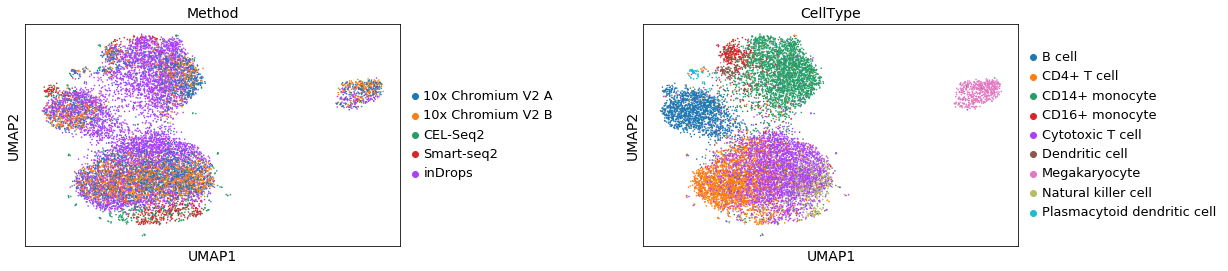

In [20]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)

# Perfroming architecture Surgery

In [19]:
new_network = surgeon.operate(network, 
                              new_condition=target_condition,
                              init='Xavier', 
                              freeze=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2448)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 4)            0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 2452)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
first_layer (Dense)             (None, 512)          1255424     concatenate_3[0][0]              
__________

In [20]:
new_network.condition_encoder

{'Baron': 0, 'Muraro': 1, 'Wang': 2, 'Segerstolpe': 3}

## Train with small new dataset containing out-of-sample condition

In [21]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_out_of_sample, 0.85)

In [22]:
train_adata.shape, valid_adata.shape

((2858, 2448), (505, 2448))

In [23]:
new_network.train(train_adata,
                  valid_adata, 
                  condition_key=condition_key,
                  le=new_network.condition_encoder, 
                  n_epochs=100,
                  batch_size=128, 
                  early_stop_limit=25,
                  lr_reducer=20, 
                  save=True, 
                  verbose=2)

Train on 2858 samples, validate on 505 samples
Epoch 1/100
 - 1s - loss: 1078.5296 - kl_recon_loss: 1078.5296 - val_loss: 1062.5228 - val_kl_recon_loss: 1062.5228
Epoch 2/100
 - 0s - loss: 1063.2248 - kl_recon_loss: 1063.2248 - val_loss: 1056.5872 - val_kl_recon_loss: 1056.5872
Epoch 3/100
 - 0s - loss: 1057.5888 - kl_recon_loss: 1057.5888 - val_loss: 1053.5201 - val_kl_recon_loss: 1053.5201
Epoch 4/100
 - 0s - loss: 1053.8980 - kl_recon_loss: 1053.8980 - val_loss: 1051.6894 - val_kl_recon_loss: 1051.6894
Epoch 5/100
 - 0s - loss: 1051.2250 - kl_recon_loss: 1051.2250 - val_loss: 1050.4651 - val_kl_recon_loss: 1050.4651
Epoch 6/100
 - 0s - loss: 1048.9098 - kl_recon_loss: 1048.9098 - val_loss: 1049.4907 - val_kl_recon_loss: 1049.4907
Epoch 7/100
 - 0s - loss: 1047.7076 - kl_recon_loss: 1047.7076 - val_loss: 1048.7288 - val_kl_recon_loss: 1048.7288
Epoch 8/100
 - 0s - loss: 1046.3563 - kl_recon_loss: 1046.3563 - val_loss: 1048.1704 - val_kl_recon_loss: 1048.1704
Epoch 9/100
 - 0s - loss:

In [24]:
encoder_labels, _ = surgeon.utils.label_encoder(adata, label_encoder=new_network.condition_encoder, condition_key=condition_key)

In [25]:
adata.obs[condition_key].value_counts()

Baron          8569
Segerstolpe    3363
Muraro         2126
Wang            635
Name: sample, dtype: int64

In [26]:
latent_adata = new_network.to_latent(adata, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 14693 × 20 
    obs: 'celltype', 'sample', 'n_genes', 'batch', 'n_counts', 'louvain'

In [27]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

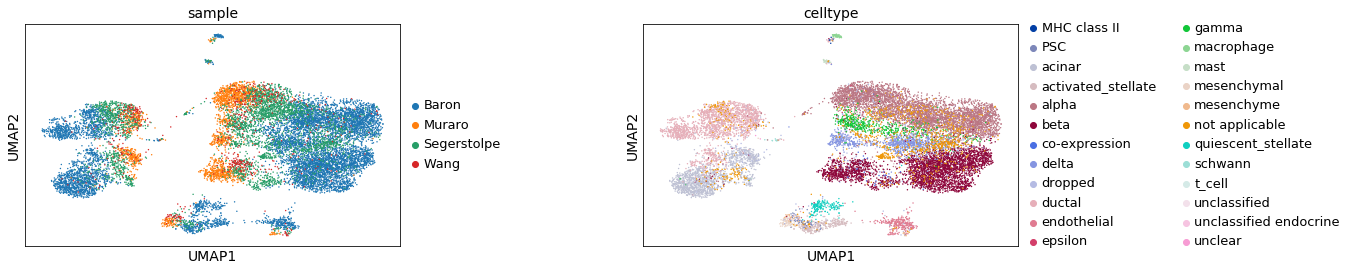

In [28]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)